# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import multilabel_confusion_matrix
from keras.optimizers import Adamax, Adagrad, RMSprop, Adam
from sklearn.model_selection import KFold, StratifiedKFold

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections [FACEMESH_TESSELATION]
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)) 

# Test MediaPipe Function with real camera 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [2]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/GitHub/TSL_Recognition/TSL10/Extracted_Keypoints') 

# Actions that we try to detect
# actions = np.array(['hello'])

actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])

# Thirty videos worth of data
no_sequences = 75

# Videos are going to be 30 frames in length
sequence_length = 30

# Prepare Data for train and test

In [3]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [4]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
X_train.shape

(525, 30, 1662)

# Train model

Train BiLSTM Model

In [21]:
# K-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracy_scores = []
loss_scores = []
train_loss_scores = []
train_accuracy_scores = []

for train_index, test_index in skf.split(X, labels):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_BiLSTM = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662))),
        Dropout(0.1),
        Bidirectional(LSTM(128, return_sequences=True, activation='relu')),
        Dropout(0.1),
        Bidirectional(LSTM(64, return_sequences=False, activation='relu')),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(actions.shape[0], activation='softmax')
    ])

    model_BiLSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model_BiLSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=512)

    _, accuracy = model_BiLSTM.evaluate(X_test, y_test)
    accuracy_scores.append(accuracy)
    loss_scores.append(history.history['loss'])
    train_loss_scores.append(history.history['loss'])
    train_accuracy_scores.append(history.history['categorical_accuracy'])

Epoch 1/500
2/2 [==============================] - 21s 4s/step - loss: 7.0193 - categorical_accuracy: 0.1100 - val_loss: 2.5107 - val_categorical_accuracy: 0.1000
Epoch 2/500
2/2 [==============================] - 4s 2s/step - loss: 3.2468 - categorical_accuracy: 0.1233 - val_loss: 3.6513 - val_categorical_accuracy: 0.1133
Epoch 3/500
2/2 [==============================] - 4s 1s/step - loss: 3.8562 - categorical_accuracy: 0.1067 - val_loss: 3.4578 - val_categorical_accuracy: 0.1200
Epoch 4/500
2/2 [==============================] - 4s 1s/step - loss: 3.6067 - categorical_accuracy: 0.0933 - val_loss: 2.3076 - val_categorical_accuracy: 0.1000
Epoch 5/500
2/2 [==============================] - 4s 2s/step - loss: 2.4232 - categorical_accuracy: 0.1067 - val_loss: 2.3814 - val_categorical_accuracy: 0.0600
Epoch 6/500
2/2 [==============================] - 4s 2s/step - loss: 2.4217 - categorical_accuracy: 0.1200 - val_loss: 2.2862 - val_categorical_accuracy: 0.1133
Epoch 7/500
2/2 [==========

KeyboardInterrupt: 

In [ ]:
for fold, loss in enumerate(loss_scores):
    print(f"Loss for Fold {fold+1}: {loss[-1]}")

mean_loss = np.mean([loss[-1] for loss in loss_scores])
print("Mean loss:", mean_loss)

print("Accuracy scores for each fold:", accuracy_scores)
print("Mean accuracy:", np.mean(accuracy_scores))

for fold, train_loss in enumerate(train_loss_scores):
    plt.plot(train_loss, label=f'Train Loss (Fold {fold+1})')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

for fold, train_accuracy in enumerate(train_accuracy_scores):
  plt.plot(train_accuracy, label=f'Train Accuracy (Fold {fold+1})')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
# lr = 0.1 # learning rate value
optimizer = Adamax()

model_BiLSTM = Sequential([
    Bidirectional(LSTM(64, return_sequences=True,
                  activation='relu', input_shape=(30, 1662))),
    Dropout(0.1),
    Bidirectional(LSTM(128, return_sequences=True, activation='relu')),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False, activation='relu')),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax')])

model_BiLSTM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[
                     'categorical_accuracy'])
model_BiLSTM.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=600, batch_size=512)

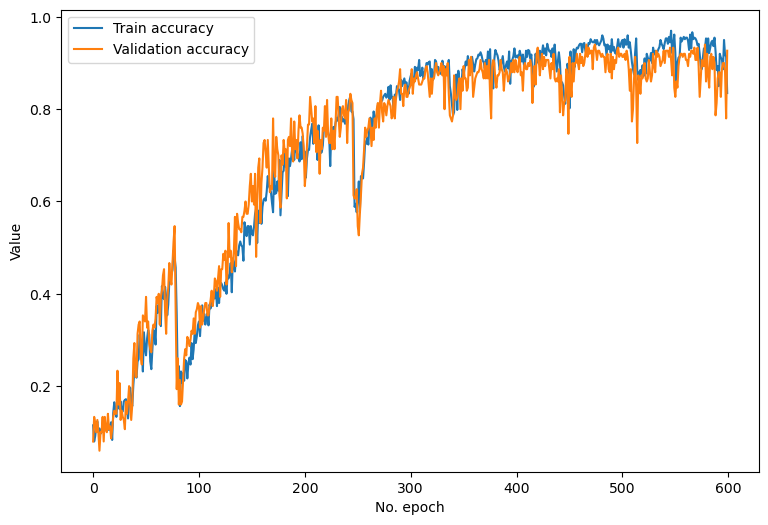

In [14]:
plt.figure(figsize=(9,6))
plt.plot(model_BiLSTM.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_BiLSTM.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

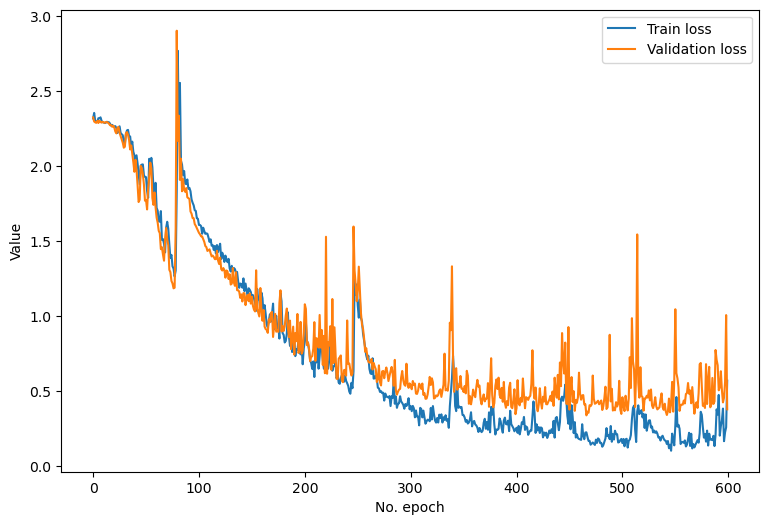

In [15]:
plt.figure(figsize=(9,6))
plt.plot(model_BiLSTM.history.history['loss'], label='Train loss')
plt.plot(model_BiLSTM.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [16]:
model_BiLSTM.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_27 (Bidirecti  (None, 30, 128)          884224    
 onal)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 30, 128)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 30, 256)          263168    
 onal)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 30, 256)           0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                      

In [17]:
model_BiLSTM.save('../BiLSTM/BiLSTM_Model.h5')

In [18]:
model_BiLSTM = load_model('../BiLSTM/BiLSTM_Model.h5')

Test Accuracy Model

In [19]:
yhat = model_BiLSTM.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_BiLSTM.evaluate(X_train, y_train)
model_BiLSTM.evaluate(X_test, y_test)

5/5 [==============================] - 1s 189ms/step - loss: 0.3770 - categorical_accuracy: 0.9267


[0.3769685924053192, 0.9266666769981384]

In [20]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[135,   0],
        [  1,  14]],

       [[134,   1],
        [  2,  13]],

       [[135,   0],
        [  2,  13]],

       [[130,   5],
        [  2,  13]],

       [[134,   1],
        [  1,  14]],

       [[134,   1],
        [  0,  15]],

       [[135,   0],
        [  0,  15]],

       [[134,   1],
        [  0,  15]],

       [[135,   0],
        [  2,  13]],

       [[133,   2],
        [  1,  14]]], dtype=int64)

# Test Model in real time

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.9

cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_BiLSTM.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.5

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
path = f'./Realtime_Video_Test/output_{timestamp}.mp4'
out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (640, 480))

cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_BiLSTM.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)
        out.write(image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()